# Classical Forecasting for Exchange Rates


In this notebook, we will explore the classical forecasting methods. 

To gain familiarity with the dataset, look at the predecessor notebook on exploratory analysis of the dataset. 
We will build the following methods 

- ARIMA: Auto-Regressive Integrate Moving Average Models
- Holt-Winters Model: Exponential Smoothing modeling of time series forecasting. 
- Vector Auto-Regression: Modeling mutliple time series together as a vector.

At the end of this notebook, we will be able to compare the above methods on the MASE metric. 
We will learn the drawbacks of MAE and empirically inspire the use of MASE.
We will estimate MASE for different horizons.
We will plot the predictions by these models and compare them visually. 


## Setup

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random 
import pandas as pd

import utils_tfb
import utils

from tqdm.notebook import tqdm
from IPython.display import display

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

PLOTTING_COLORS = utils.PLOTTING_COLORS

FORECASTING_HORIZON = [4, 8, 12]

%load_ext autoreload
%autoreload 2

In [2]:
data = utils.load_tutotrial_data(dataset='exchange_rate')
data.index

DatetimeIndex(['1990-01-07', '1990-01-14', '1990-01-21', '1990-01-28',
               '1990-02-04', '1990-02-11', '1990-02-18', '1990-02-25',
               '1990-03-04', '1990-03-11',
               ...
               '2010-08-08', '2010-08-15', '2010-08-22', '2010-08-29',
               '2010-09-05', '2010-09-12', '2010-09-19', '2010-09-26',
               '2010-10-03', '2010-10-10'],
              dtype='datetime64[ns]', name='date', length=1084, freq='W-SUN')

## Train-Test Splitting

In [3]:
train_size = int(len(data) * 0.9)
test_size = int(len(data) * 0.1)
train_val_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

max_horizon = max(FORECASTING_HORIZON)
train_data, val_data = train_val_data.iloc[:-max_horizon], train_val_data.iloc[-max_horizon:]

print(f"Number of steps in training data: {len(train_data)}\nNumber of steps in test data: {len(test_data)}")

Number of steps in training data: 963
Number of steps in test data: 109


## ARIMA

From the previous notebook, we observed that there is no seasonality in the data. 
As a result, we will fit the ARIMA model instead. 
We still need to find the best parameters for each time series. 
So we will run a grid search to do so. 

If you are interested in finding the best parameters wthout having to go for grid search, checkout `pmdarima.auto_arima` ([documentation here](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA))

Recall, that these models minimize an objective (likelihood), which is encapsulated in Akaike-Information Criterion (AIC). As a result, the model with the best AIC should be more appropriate for the time series at hand. To check whether this corresponds to MASE, we will also compute this metric on validation set and track the parameters that perform best on MASE.

*Note*: Some parameters might lead to warning as the underlying model might be underconstrained. 

In [4]:
# define the grid
p_values = q_values = range(0, 4)
d_values = range(0, 1, 2)
pdq = list(itertools.product(p_values, d_values, q_values))

In [5]:
# Grid search
# Note: we are not specifying seasonal order. it defaults to ARIMA.

# only for understanding
best_aic = {}
best_aic_model = {}

# we will use the models with best mase on validation dataset
best_mase = {}
best_mase_model = {}
for col in tqdm(train_data.columns):
    ts = train_data[col]
    best_aic[col] = np.inf
    best_mase[col] = np.inf
    
    for p,d,q in pdq:
        model = SARIMAX(
            ts,
            trend="c",
            order=(p, d, q),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
    
        results = model.fit(disp=False)
        predictions = results.get_forecast(steps=len(val_data)) # how to get forecasts?

        # SARIMAX returns mean and standard errors
        forecast = predictions.predicted_mean.values 
        actual = val_data[col].values
        mase = utils.mean_absolute_scaled_error(forecast, actual, insample_data=ts.values)

        if mase < best_mase[col]:
            best_mase[col] = mase
            best_mase_model[col] = (model, results, (p, d, q))
        
        if results.aic < best_aic[col]:
            best_aic[col] = results.aic
            best_aic_model[col] = (model, results, (p, d, q))
    
    print(f"Col: {col}. Best AIC parameters: {best_aic_model[col][-1]}. Best AIC:{best_aic[col]}. Best Mase: {best_mase[col]}. Best Mase Parameters: {best_mase_model[col][-1]}")

  0%|          | 0/8 [00:00<?, ?it/s]

Col: 0. Best AIC parameters: (1, 0, 1). Best AIC:-5895.888382873427. Best Mase: 5.781807254633042. Best Mase Parameters: (2, 0, 0)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Col: 1. Best AIC parameters: (1, 0, 1). Best AIC:-4730.411222589351. Best Mase: 3.201042621167855. Best Mase Parameters: (3, 0, 2)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Col: 2. Best AIC parameters: (1, 0, 1). Best AIC:-6451.549531278127. Best Mase: 3.984174534749476. Best Mase Parameters: (1, 0, 0)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Col: 3. Best AIC parameters: (1, 0, 1). Best AIC:-5790.962893151665. Best Mase: 3.5053725722050366. Best Mase Parameters: (2, 0, 0)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Col: 4. Best AIC parameters: (1, 0, 1). Best AIC:-9711.851407513852. Best Mase: 4.720374360976269. Best Mase Parameters: (3, 0, 2)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/hom

Col: 5. Best AIC parameters: (2, 0, 0). Best AIC:-14493.020973081102. Best Mase: 3.4968622686736044. Best Mase Parameters: (0, 0, 1)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Col: 6. Best AIC parameters: (1, 0, 1). Best AIC:-7666.677632735811. Best Mase: 1.8239711582885785. Best Mase Parameters: (3, 0, 2)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Col: OT. Best AIC parameters: (3, 0, 2). Best AIC:-6209.380272557676. Best Mase: 5.321401848743822. Best Mase Parameters: (2, 0, 0)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Metrics On Test Data

Observe that the best parameters according to the two criterion - AIC and MASE differ quite a lot. 

To measure the performance on the test data, we will retrain the model on the combined train-val dataset, and compute the MASE metric on the test dataset. 

We also store test_predictions so that we can compare these predictions later on with other methods.

In [6]:
test_predictions = {}
best_model_metrics = {}
for col in test_data.columns:
    best_model_metrics[col] = {}
    ts = train_val_data[col]
    
    # retrain the model with best mase parameters on train_val_data
    p, d, q = best_mase_model[col][2]
    ts = train_val_data[col]
    model = SARIMAX(
        ts,
        trend="c",
        order=(p, d, q),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    results = model.fit(disp=False)

    # get metrics and predictions
    predictions = results.get_forecast(steps=len(test_data))
    test_predictions[f"arima_{col}_mean"] = predictions.predicted_mean.values
    test_predictions[f"arima_{col}_se"] = predictions.se_mean.values
    
    for horizon in FORECASTING_HORIZON + [len(test_data)]:
        forecast = predictions.predicted_mean[:horizon].values
        actual = test_data[col][:horizon].values
        best_model_metrics[col][horizon] = utils.get_all_metrics(forecast, actual, insample_data=ts.values)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [7]:

records = []
for col in train_data.columns:
    for horizon, metrics in best_model_metrics[col].items():
        records.append({
            'col': col,
            'horizon': horizon,
            'model': 'arima',
            **metrics
        })


# Store these metrics to be able to compare them against other methods later on
results = pd.DataFrame(records)
results.to_csv('metrics_tutorial_exchange_rate.csv', index=False)
results.head()

,col,horizon,model,mae,mase,rse,mse
0,0,4,arima,0.027769,3.303097,0.348771,0.000934
1,0,8,arima,0.035188,4.185681,0.723671,0.001380
2,0,12,arima,0.048143,5.726703,2.156340,0.002752
3,0,109,arima,0.091198,10.848062,5.043893,0.009139
4,1,4,arima,0.007798,0.503031,0.009849,0.000079


In [8]:
mean_df = results.groupby(['horizon', 'model']).mean(['mase', 'mae', 'rse', 'mse']).reset_index()
mean_df['col'] = 'overall'

results = pd.concat([results, mean_df])
results.head()

,col,horizon,model,mae,mase,rse,mse
0,0,4,arima,0.027769,3.303097,0.348771,0.000934
1,0,8,arima,0.035188,4.185681,0.723671,0.001380
2,0,12,arima,0.048143,5.726703,2.156340,0.002752
3,0,109,arima,0.091198,10.848062,5.043893,0.009139
4,1,4,arima,0.007798,0.503031,0.009849,0.000079


**Metrics:**
We see that even though MAE values are very low, MASE indicates that a MAE naive can still do better. 
We will use MASE metric from now on to compare the models

Similarly, it's evident that RSE is much better than MSE as it says something about how much better one can do relative to predicting the historical mean. Any value greater than 1 means you can do better by just predicting the mean of the past values.

In [9]:
results_df = results.pivot_table(index=['model'], columns=['horizon', 'col'], values='mase')
for h in results.horizon.unique():
    print("#"*50, f"Horizon: {h}", "#"*50)
    df = results_df[h]
    styled_df = df.style.apply(utils.highlight_min, axis=0)
    display(styled_df)
    print("\n")

################################################## Horizon: 4 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
arima,3.303097,0.503031,3.180161,0.682720,3.674278,9.561702,20.442501,1.066780,5.301784




################################################## Horizon: 8 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
arima,4.185681,1.976171,5.549969,3.160463,4.270595,9.759802,72.910234,1.190410,12.875416




################################################## Horizon: 12 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
arima,5.726703,2.566224,8.575194,4.097075,5.052545,9.743780,454.596015,2.648813,61.625793




################################################## Horizon: 109 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
arima,10.848062,10.959112,18.135859,2.909563,7.695043,8.044450,18167891950996966632062976.000000,8.681124,2270986493874620829007872.000000


### Store Predictions 

We will save predictions to be able to compare them later against other methods.

In [10]:
test_predictions = pd.DataFrame(test_predictions)
test_predictions.index = test_data.index
test_predictions.to_csv("test_predictions_tutorial_exchange_rate.csv")

In [11]:
test_predictions.head()

,arima_0_mean,arima_0_se,arima_1_mean,arima_1_se,arima_2_mean,arima_2_se,arima_3_mean,arima_3_se,arima_4_mean,arima_4_se,arima_5_mean,arima_5_se,arima_6_mean,arima_6_se,arima_OT_mean,arima_OT_se
date,,,,,,,,,,,,,,,,
2008-09-14,0.858606,0.011221,1.572000,0.020492,0.888298,0.008540,1.033045,0.011899,0.162975,0.001529,0.009115,0.001038,0.780780,0.016054,0.785140,0.009563
2008-09-21,0.857681,0.017830,1.572908,0.033524,0.888180,0.012063,1.032039,0.019298,0.162848,0.002495,0.009415,0.001139,0.813636,0.058603,0.784486,0.015074
2008-09-28,0.857204,0.022939,1.573756,0.043135,0.888062,0.014757,1.031341,0.025110,0.162720,0.003168,0.009415,0.001139,0.857572,0.119010,0.783985,0.019313
2008-10-05,0.856836,0.027145,1.574671,0.050937,0.887945,0.017020,1.030731,0.029912,0.162594,0.003718,0.009415,0.001139,0.862996,0.151271,0.783520,0.022802
2008-10-12,0.856496,0.030763,1.575655,0.057613,0.887828,0.019006,1.030148,0.034043,0.162467,0.004195,0.009415,0.001139,0.741439,0.169558,0.783065,0.025809


### Plot predictions

Feel free to change the column and see how well does the ARIMA model does.

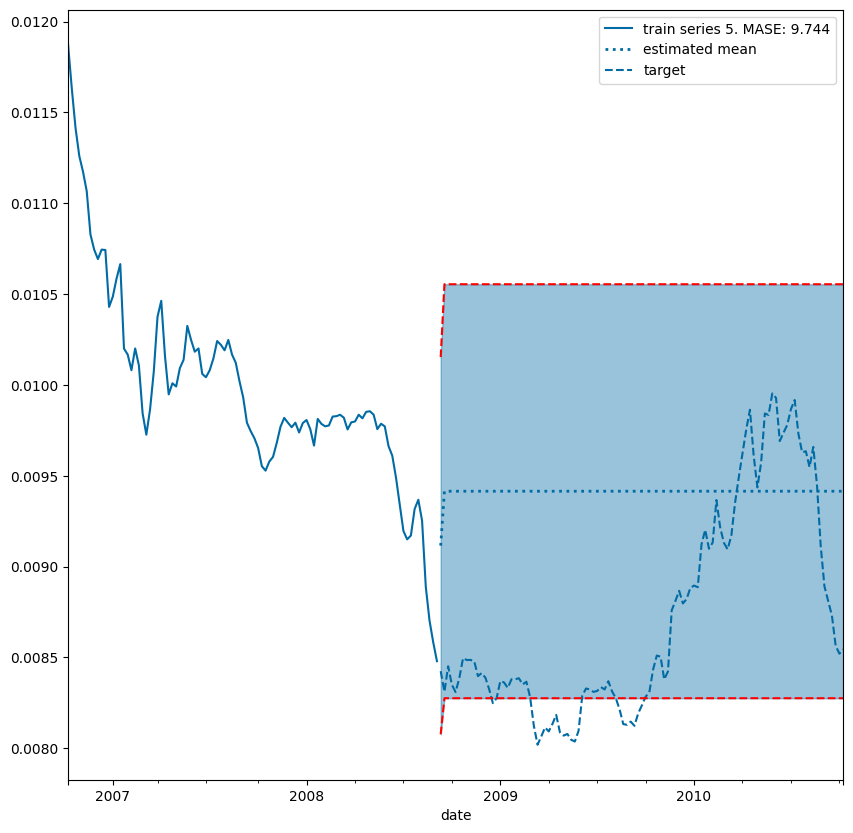

In [12]:
# plot predictions
col = random.choice(train_data.columns)
n_history_to_plot = 100
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
color = PLOTTING_COLORS[0]

max_horizon = max(FORECASTING_HORIZON)
mase = best_model_metrics[col][max_horizon]['mase']
train_val_data[col][-n_history_to_plot:].plot(ax=ax, color=color, label=f'train series {col}. MASE:{mase: 0.3f}')

mean = test_predictions[f"arima_{col}_mean"]
se = test_predictions[f"arima_{col}_se"]

#
mean.plot(ax=ax, color=color, linestyle=':', linewidth=2, label='estimated mean')
ax.fill_between(se.index, mean.values - se.values, se.values + mean.values, color=color, alpha=0.4)
test_data[col].plot(ax=ax, color=color, linestyle='--', label='target')
(mean-se).plot(ax=ax, color='red', linestyle='--')
(mean+se).plot(ax=ax, color='red', linestyle='--')

ax.legend()

## Exponential Smoothing Models

Here we will build models using Holt's Linear Trend and Holt-Winter's extension to account for seasonality.

In [13]:
best_mase, best_mase_model = {}, {}
for col in train_data.columns:
    best_mase[col] = np.inf
    best_mase_model[col] = {}

    # Holt's Linear Trend Model
    model = SimpleExpSmoothing(train_data[col], initialization_method="estimated").fit()
    y_pred = model.forecast(len(val_data))
    mase = utils.mean_absolute_scaled_error(y_pred.values, val_data[col].values, train_data[col].values)

    best_mase[col], best_mase_model[col] = mase, (model, model.aic, 0)
    for s in [7, 30, 365]:
        # Holt-Winter's Model
        model = ExponentialSmoothing(train_data[col], trend='add',  seasonal='add', seasonal_periods=s, initialization_method="estimated")
        model = model.fit()
        y_pred = model.forecast(len(val_data))
        mase = utils.mean_absolute_scaled_error(y_pred.values, val_data[col].values, train_data[col].values)
        
        if mase < best_mase[col]:
            best_mase[col] = mase
            best_mase_model[col] = (model, model.aic, s)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/zeus

In [14]:
print("Best paramerters")
for col in train_data.columns:
    mase = best_mase[col]
    s = best_mase_model[col][2]
    print(f"Col: {col}\tValidation-MASE:{mase: 0.3f}\tSeasonality:{s}")

Best paramerters
Col: 0	Validation-MASE: 4.720	Seasonality:365
Col: 1	Validation-MASE: 2.775	Seasonality:30
Col: 2	Validation-MASE: 4.051	Seasonality:7
Col: 3	Validation-MASE: 2.018	Seasonality:365
Col: 4	Validation-MASE: 0.983	Seasonality:30
Col: 5	Validation-MASE: 1.550	Seasonality:365
Col: 6	Validation-MASE: 5.502	Seasonality:0
Col: OT	Validation-MASE: 5.793	Seasonality:30


### Collect metrics on test data

In [15]:
test_predictions = {}
best_model_metrics = {}
for col in test_data.columns:
    best_model_metrics[col] = {}
    ts = train_val_data[col]
    
    # retrain the model with best mase parameters on train_val_data
    s = best_mase_model[col][2]
    if s == 0:
        model = SimpleExpSmoothing(ts, initialization_method="estimated")
    else:
        model = ExponentialSmoothing(ts, trend='add',  seasonal='add', seasonal_periods=s, initialization_method="estimated")
    
    model = model.fit()

    # get metrics and predictions
    predictions = model.forecast(len(test_data))
    test_predictions[f"expsmooth_{col}_mean"] = predictions.values
    
    for horizon in FORECASTING_HORIZON + [len(test_data)]:
        forecast = predictions[:horizon].values
        actual = test_data[col][:horizon].values
        best_model_metrics[col][horizon] = utils.get_all_metrics(forecast, actual, insample_data=ts.values)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [16]:
records = []
for col in train_data.columns:
    for horizon, metrics in best_model_metrics[col].items():
        records.append({
            'col': col,
            'horizon': horizon,
            'model': 'expsmooth',
            **metrics
        })


results = utils.update_results(records)
results.head()

Existing size of the results: (32, 7)
Existing methods in results: ['arima']
New size of the results: (64, 7)
New methods in results: ['arima' 'expsmooth']


,col,horizon,model,mae,mase,rse,mse
0,0,4,arima,0.027769,3.303097,0.348771,0.000934
1,0,8,arima,0.035188,4.185681,0.723671,0.001380
2,0,12,arima,0.048143,5.726703,2.156340,0.002752
3,0,109,arima,0.091198,10.848062,5.043893,0.009139
4,1,4,arima,0.007798,0.503031,0.009849,0.000079


In [17]:
utils.display_results(results)

################################################## Horizon: 4 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
arima,3.303097,0.503031,3.180161,0.682720,3.674278,9.561702,20.442501,1.066780,5.301784
expsmooth,3.404328,0.464998,3.370442,0.553352,2.198699,2.477867,2.301333,1.759943,2.066370




################################################## Horizon: 8 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
arima,4.185681,1.976171,5.549969,3.160463,4.270595,9.759802,72.910234,1.190410,12.875416
expsmooth,4.777325,2.003466,5.777208,3.145735,2.413226,3.454392,3.924996,2.056302,3.444081




################################################## Horizon: 12 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
arima,5.726703,2.566224,8.575194,4.097075,5.052545,9.743780,454.596015,2.648813,61.625793
expsmooth,6.070442,2.456829,8.843545,3.979424,4.373034,3.823619,5.656252,3.614446,4.852199




################################################## Horizon: 109 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
arima,10.848062,10.959112,18.135859,2.909563,7.695043,8.044450,18167891950996968779546624.000000,8.681124,2270986493874621097443328.000000
expsmooth,11.226121,8.125427,19.490751,3.914774,29.159141,13.700770,12.651490,13.749523,14.002250


### Save test predictions


In [18]:
test_predictions = utils.update_test_predictions(test_predictions)
test_predictions.head()

New columns: Index(['arima_0_mean', 'arima_0_se', 'arima_1_mean', 'arima_1_se',
       'arima_2_mean', 'arima_2_se', 'arima_3_mean', 'arima_3_se',
       'arima_4_mean', 'arima_4_se', 'arima_5_mean', 'arima_5_se',
       'arima_6_mean', 'arima_6_se', 'arima_OT_mean', 'arima_OT_se',
       'expsmooth_0_mean', 'expsmooth_1_mean', 'expsmooth_2_mean',
       'expsmooth_3_mean', 'expsmooth_4_mean', 'expsmooth_5_mean',
       'expsmooth_6_mean', 'expsmooth_OT_mean'],
      dtype='object')


,arima_0_mean,arima_0_se,arima_1_mean,arima_1_se,arima_2_mean,arima_2_se,arima_3_mean,arima_3_se,arima_4_mean,arima_4_se,...,arima_OT_mean,arima_OT_se,expsmooth_0_mean,expsmooth_1_mean,expsmooth_2_mean,expsmooth_3_mean,expsmooth_4_mean,expsmooth_5_mean,expsmooth_6_mean,expsmooth_OT_mean
date,,,,,,,,,,,,,,,,,,,,,
2008-09-14,0.858606,0.011221,1.572000,0.020492,0.888298,0.008540,1.033045,0.011899,0.162975,0.001529,...,0.785140,0.009563,0.860025,1.571947,0.889858,1.034006,0.162030,0.008234,0.769111,0.789512
2008-09-21,0.857681,0.017830,1.572908,0.033524,0.888180,0.012063,1.032039,0.019298,0.162848,0.002495,...,0.784486,0.015074,0.855792,1.571479,0.889881,1.029448,0.161462,0.008057,0.769111,0.790135
2008-09-28,0.857204,0.022939,1.573756,0.043135,0.888062,0.014757,1.031341,0.025110,0.162720,0.003168,...,0.783985,0.019313,0.856407,1.572656,0.889460,1.024775,0.161417,0.008075,0.769111,0.788873
2008-10-05,0.856836,0.027145,1.574671,0.050937,0.887945,0.017020,1.030731,0.029912,0.162594,0.003718,...,0.783520,0.022802,0.861509,1.574895,0.887864,1.022114,0.161448,0.008180,0.769111,0.788352
2008-10-12,0.856496,0.030763,1.575655,0.057613,0.887828,0.019006,1.030148,0.034043,0.162467,0.004195,...,0.783065,0.025809,0.870092,1.573373,0.889194,1.035831,0.161516,0.008082,0.769111,0.789020


### Visualize the predictions

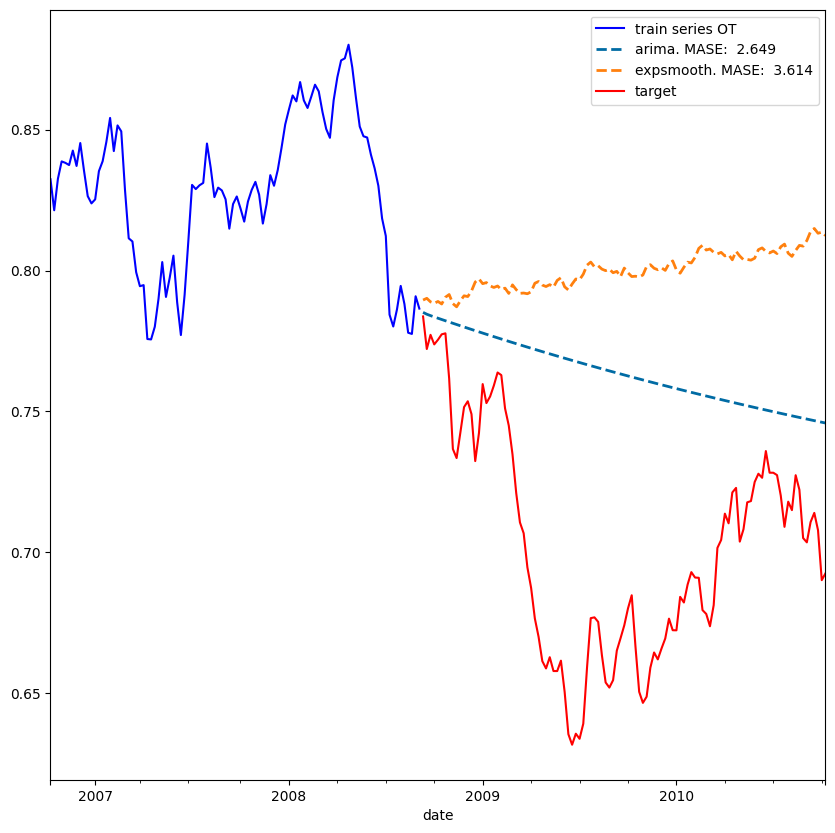

In [19]:
# plot predictions
col = random.choice(train_data.columns)
n_history_to_plot = 100
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)


max_horizon = max(FORECASTING_HORIZON)
train_val_data[col][-n_history_to_plot:].plot(ax=ax, color='blue', label=f'train series {col}')

for idx, model in enumerate(results['model'].unique()):
    color = PLOTTING_COLORS[idx % len(PLOTTING_COLORS)]

    mase = results[(results['col'] == col) & (results['model'] == model) & (results['horizon'] == max_horizon)]['mase'].item()
    
    mean = test_predictions[f"{model}_{col}_mean"]
    mean.plot(ax=ax, color=color, linestyle='--', linewidth=2, label=f'{model}. MASE: {mase: 0.3f}')

#

# ax.fill_between(se.index, mean.values - se.values, se.values + mean.values, color=color, alpha=0.4)
test_data[col].plot(ax=ax, color='red', linestyle='-', label='target')

ax.legend()

## Vector Auto-Regression (VAR)

As the name suggests, VAR models auto-regress on vectors rather than scalar as in univariate time series. 
VAR models follow a simple mathematical formulation, and are trained using Maximum Likelihood Estimation (MLE) principles. 
These are somewhat different from VARMA models which involve error terms and are optimized using iterative MLE. 

For this tutorial, we will only look at VAR models, but feel free to test out the VARMA models using `VARMAX` module. Refer to the [documentation](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.varmax.VARMAX.html#statsmodels.tsa.statespace.varmax.VARMAX) of VARMAX for more details. One can test several hyperparameters with VARMAX models which include both AR and MA models in multi-variate regression. 
Here, for the sake of time, we will be looking at VAR models with explicit differencing since they are faster to train.

**Evaluation:** Note that the evaluation metric will have to be average MASE across the columns. 


### Simple VAR

In [20]:
def train_var(train_data, forecast_horizon):
    model = VAR(train_data)
    results = model.fit(maxlags=15, ic='aic') # note it will automatically select the best order for AR
    
    lag_order = results.k_ar # best chosen order
    forecasted_values = results.forecast(train_data.values[-lag_order:], steps=forecast_horizon)

    date_range = pd.date_range(start=train_data.index[-1], periods=forecast_horizon+1, freq=train_data.index.freq)
    date_range = date_range[1:] # we don't need the last index of train

    forecasted_df = pd.DataFrame(forecasted_values, index=date_range, columns=train_data.columns)
    
    return model, results, forecasted_df

In [21]:
model, results, forecasted_df = train_var(train_data, forecast_horizon=len(val_data))

all_mase_simple_var = utils.get_mase(forecasted_df, val_data, train_data)
avg_mase_simple_var = np.mean(list(all_mase_simple_var.values()))
avg_mase_simple_var

4.100213241606214

### VAR with Differencing

Another way to induce complexity in VAR models is to use explicit differencing. This is the same as "I" in ARIMA models. 
However, we do it explicity here. 

In [22]:
train_data_diff = train_data.diff().dropna() # take differences with respect the previous observation

model, results, forecasted_df = train_var(train_data_diff, forecast_horizon=len(val_data))

# IMPORTANT: We need to transform our forecast to account for differencing.
def invert_transformation(df_train, df_forecast):
    """Transforms the diff forecasts to actual values."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

# We pass train_data so that the predictions on diff could be continued from its last value
forecast_reverted = invert_transformation(train_data, forecasted_df)

all_mase_var_diff = utils.get_mase(forecast_reverted, val_data, train_data)
avg_mase_var_diff = np.mean(list(all_mase_var_diff.values()))
avg_mase_var_diff

4.721277433843638

### Metrics On Test Data

We observe that the simple VAR model is better, so we use that here.

In [23]:
model, results, forecasted_df = train_var(train_val_data, forecast_horizon=len(test_data))

records = []
for horizon in FORECASTING_HORIZON + [len(test_data)]:
    all_mase_test = utils.get_mase(forecasted_df, test_data, train_val_data, horizon)
    for col in all_mase_test:
        records.append({
            "col": col,
            "horizon": horizon,
            "model": "VAR",
            "mase": all_mase_test[col],
        })

results = utils.update_results(records)

Existing size of the results: (64, 7)
Existing methods in results: ['arima' 'expsmooth']
New size of the results: (96, 7)
New methods in results: ['arima' 'expsmooth' 'VAR']


In [24]:
utils.display_results(results)

################################################## Horizon: 4 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
VAR,3.166432,0.639096,2.641878,0.671097,4.085059,0.655386,1.413583,1.020601,1.786641
arima,3.303097,0.503031,3.180161,0.682720,3.674278,9.561702,20.442501,1.066780,5.301784
expsmooth,3.404328,0.464998,3.370442,0.553352,2.198699,2.477867,2.301333,1.759943,2.066370




################################################## Horizon: 8 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
VAR,3.950052,2.242457,4.592764,3.174524,5.016073,0.667765,2.578697,1.111311,2.916705
arima,4.185681,1.976171,5.549969,3.160463,4.270595,9.759802,72.910234,1.190410,12.875416
expsmooth,4.777325,2.003466,5.777208,3.145735,2.413226,3.454392,3.924996,2.056302,3.444081




################################################## Horizon: 12 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
VAR,5.394239,2.913588,7.226344,4.243768,6.051204,0.580071,3.851051,2.537539,4.099725
arima,5.726703,2.566224,8.575194,4.097075,5.052545,9.743780,454.596015,2.648813,61.625793
expsmooth,6.070442,2.456829,8.843545,3.979424,4.373034,3.823619,5.656252,3.614446,4.852199




################################################## Horizon: 109 ##################################################


col,0,1,2,3,4,5,6,OT,overall
model,,,,,,,,,
VAR,7.828999,11.618052,11.012583,7.468651,4.856714,5.315669,5.824936,6.801685,7.590911
arima,10.848062,10.959112,18.135859,2.909563,7.695043,8.044450,18167891950996968779546624.000000,8.681124,2270986493874621097443328.000000
expsmooth,11.226121,8.125427,19.490751,3.914774,29.159141,13.700770,12.651490,13.749523,14.002250


## Plot predictions

In [28]:
forecasted_df.columns = [f"VAR_{col}_mean" for col in forecasted_df.columns]

In [36]:
test_predictions = utils.update_test_predictions(forecasted_df)
test_predictions.head()

New columns: Index(['arima_0_mean', 'arima_0_se', 'arima_1_mean', 'arima_1_se',
       'arima_2_mean', 'arima_2_se', 'arima_3_mean', 'arima_3_se',
       'arima_4_mean', 'arima_4_se', 'arima_5_mean', 'arima_5_se',
       'arima_6_mean', 'arima_6_se', 'arima_OT_mean', 'arima_OT_se',
       'expsmooth_0_mean', 'expsmooth_1_mean', 'expsmooth_2_mean',
       'expsmooth_3_mean', 'expsmooth_4_mean', 'expsmooth_5_mean',
       'expsmooth_6_mean', 'expsmooth_OT_mean', 'VAR_0_mean', 'VAR_1_mean',
       'VAR_2_mean', 'VAR_3_mean', 'VAR_4_mean', 'VAR_5_mean', 'VAR_6_mean',
       'VAR_OT_mean'],
      dtype='object')


,arima_0_mean,arima_0_se,arima_1_mean,arima_1_se,arima_2_mean,arima_2_se,arima_3_mean,arima_3_se,arima_4_mean,arima_4_se,...,expsmooth_6_mean,expsmooth_OT_mean,VAR_0_mean,VAR_1_mean,VAR_2_mean,VAR_3_mean,VAR_4_mean,VAR_5_mean,VAR_6_mean,VAR_OT_mean
date,,,,,,,,,,,,,,,,,,,,,
2008-09-14,0.858606,0.011221,1.572000,0.020492,0.888298,0.008540,1.033045,0.011899,0.162975,0.001529,...,0.769111,0.789512,0.858228,1.572243,0.887260,1.032492,0.163013,0.008448,0.767555,0.785108
2008-09-21,0.857681,0.017830,1.572908,0.033524,0.888180,0.012063,1.032039,0.019298,0.162848,0.002495,...,0.769111,0.790135,0.856730,1.574378,0.885564,1.031235,0.162928,0.008443,0.766512,0.784210
2008-09-28,0.857204,0.022939,1.573756,0.043135,0.888062,0.014757,1.031341,0.025110,0.162720,0.003168,...,0.769111,0.788873,0.855776,1.576518,0.884050,1.030378,0.162850,0.008446,0.765714,0.783538
2008-10-05,0.856836,0.027145,1.574671,0.050937,0.887945,0.017020,1.030731,0.029912,0.162594,0.003718,...,0.769111,0.788352,0.854998,1.578634,0.882658,1.029587,0.162772,0.008451,0.764988,0.782960
2008-10-12,0.856496,0.030763,1.575655,0.057613,0.887828,0.019006,1.030148,0.034043,0.162467,0.004195,...,0.769111,0.789020,0.854269,1.580662,0.881320,1.028764,0.162691,0.008455,0.764273,0.782412


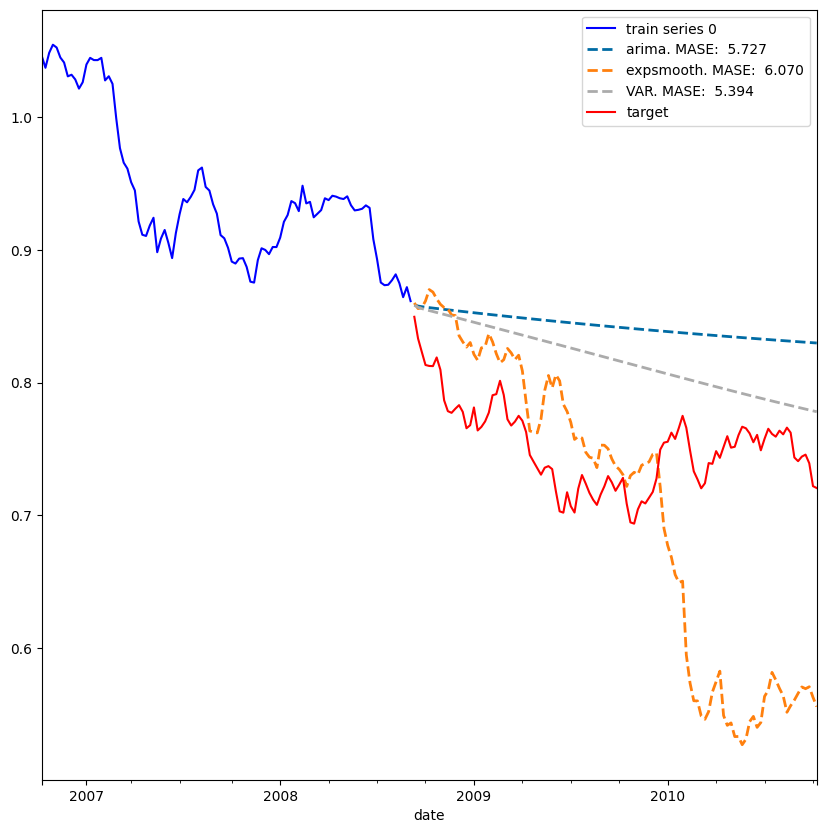

In [40]:
# plot predictions
col = random.choice(train_data.columns)
n_history_to_plot = 100
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)


max_horizon = max(FORECASTING_HORIZON)
train_val_data[col][-n_history_to_plot:].plot(ax=ax, color='blue', label=f'train series {col}')

for idx, model in enumerate(results['model'].unique()):
    color = PLOTTING_COLORS[idx % len(PLOTTING_COLORS)]

    mase = results[(results['col'] == col) & (results['model'] == model) & (results['horizon'] == max_horizon)]['mase'].item()
    
    mean = test_predictions[f"{model}_{col}_mean"]
    mean.plot(ax=ax, color=color, linestyle='--', linewidth=2, label=f'{model}. MASE: {mase: 0.3f}')

#

# ax.fill_between(se.index, mean.values - se.values, se.values + mean.values, color=color, alpha=0.4)
test_data[col].plot(ax=ax, color='red', linestyle='-', label='target')

ax.legend()

## Auto ARIMA

[`pmdarima` library](https://alkaline-ml.com/pmdarima/index.html) in python provides an automatic parameter tuning library in Python. 

Here is the [documentation](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.AutoARIMA.html#pmdarima.arima.AutoARIMA) of `pmd.auto_arima` which I encourage to read to get familiar with the parameters. 
Since it doesn't run hyperparameter search on the seasonality parameter, you will have to run a parameter selection on it, and select the one with the best AIC Score / validation score. 
